## Introduction
A simple CNN model based on the data from Kaggle. [Here](https://www.kaggle.com/competitions/dogs-vs-cats/data) you can find the data.

main points:
- I sampled small portion of data so I could run it on personal PC
- I am using .flow_from_directory in TF so I need to put each class in a seperate folder.
- No optimization was done on the model

In [23]:
import os
import random
import shutil

In [38]:
f_names = os.listdir( os.path.join(os.getcwd(),'data/train'))
# count of training data:
print(f"train count: {len(f_names)}")

train count: 25000


Sample 2000 records as new training data and 1000 records as validation data. Seperate dogs and cats in training and validation and move them to correct directories:

In [29]:
random.seed(1)
sample_data = random.sample(f_names, 3500)
train_sample  = sample_data[:2500]
validation_sample = sample_data[2500:]

# train data:
source_dir = os.path.join(os.getcwd(),'data/train')
target_dir = os.path.join(os.getcwd(),'data/sample_train')

for v in train_sample:
    if 'cat' in v.lower():
        shutil.copy(os.path.join(source_dir, v),os.path.join(target_dir, 'cat',v))
    else:
        shutil.copy(os.path.join(source_dir, v),os.path.join(target_dir, 'dog',v))

# validation data:
target_dir = os.path.join(os.getcwd(),'data/sample_validation')

for v in validation_sample:
    if 'cat' in v.lower():
        shutil.copy(os.path.join(source_dir, v),os.path.join(target_dir, 'cat',v))
    else:
        shutil.copy(os.path.join(source_dir, v),os.path.join(target_dir, 'dog',v))


In [46]:
base_dir=os.path.join(os.getcwd(),'data')
train_dir = os.path.join(base_dir, 'sample_train')
validation_dir = os.path.join(base_dir, 'sample_validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')

In [51]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:5])
print(train_dog_fnames[:5])

['cat.1577.jpg', 'cat.3360.jpg', 'cat.12034.jpg', 'cat.8221.jpg', 'cat.2056.jpg']
['dog.991.jpg', 'dog.2500.jpg', 'dog.4165.jpg', 'dog.9441.jpg', 'dog.8039.jpg']


Look at the few samples of the data:

In [48]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

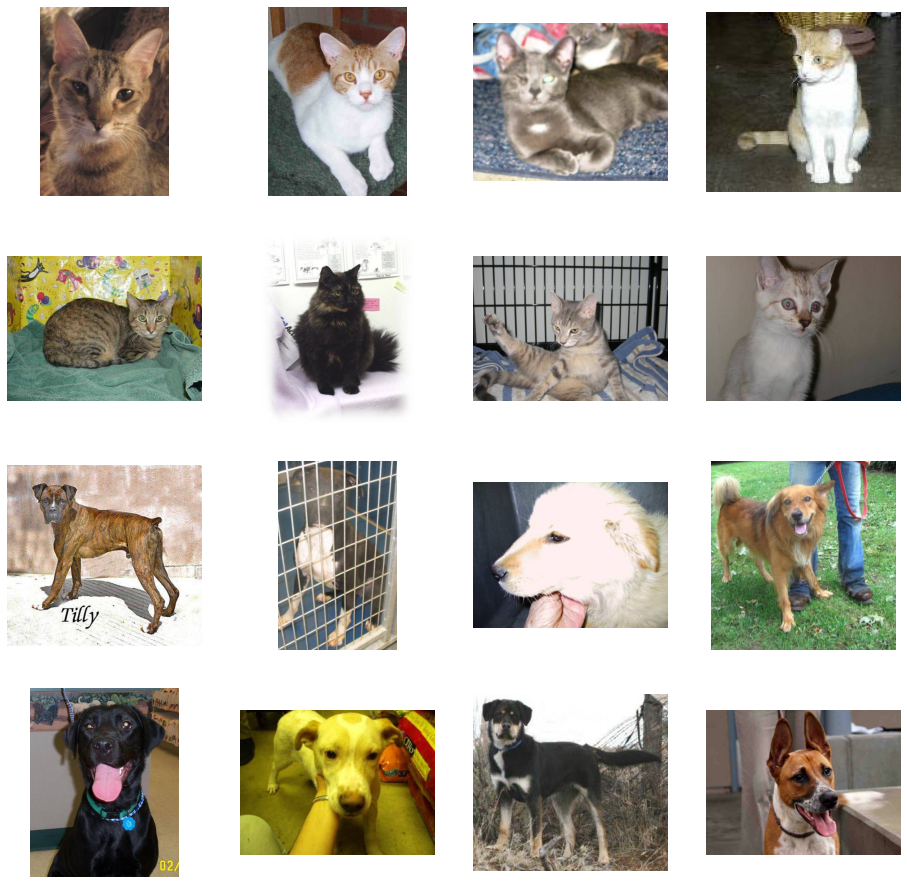

In [50]:
#Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Simple CNN model:

In [52]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [54]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

## Data pre-processing
As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras, this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory).

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2500 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Model traning:

In [57]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=2
            )

Epoch 1/15
125/125 - 65s - loss: 0.7309 - accuracy: 0.5832 - val_loss: 0.6792 - val_accuracy: 0.6070
Epoch 2/15
125/125 - 62s - loss: 0.5968 - accuracy: 0.6836 - val_loss: 0.5780 - val_accuracy: 0.7020
Epoch 3/15
125/125 - 57s - loss: 0.5301 - accuracy: 0.7428 - val_loss: 0.5394 - val_accuracy: 0.7330
Epoch 4/15
125/125 - 60s - loss: 0.4458 - accuracy: 0.7916 - val_loss: 0.5247 - val_accuracy: 0.7640
Epoch 5/15
125/125 - 60s - loss: 0.3641 - accuracy: 0.8372 - val_loss: 0.6013 - val_accuracy: 0.7480
Epoch 6/15
125/125 - 67s - loss: 0.2797 - accuracy: 0.8808 - val_loss: 0.5976 - val_accuracy: 0.7150
Epoch 7/15
125/125 - 69s - loss: 0.1849 - accuracy: 0.9308 - val_loss: 0.6576 - val_accuracy: 0.7150
Epoch 8/15
125/125 - 63s - loss: 0.1437 - accuracy: 0.9460 - val_loss: 0.8376 - val_accuracy: 0.7510
Epoch 9/15
125/125 - 62s - loss: 0.1101 - accuracy: 0.9612 - val_loss: 0.9191 - val_accuracy: 0.7360
Epoch 10/15
125/125 - 60s - loss: 0.0635 - accuracy: 0.9776 - val_loss: 1.1216 - val_accura

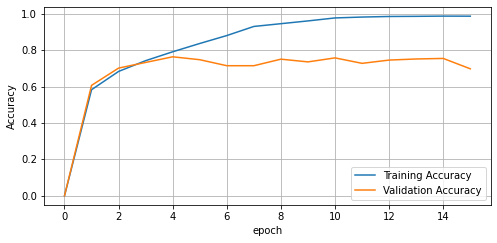

In [74]:
x = range(len(history.history['loss']))
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
y1 = [0]+history.history['accuracy']
y2 = [0]+history.history['val_accuracy']
plt.plot(y1, label='Training Accuracy')
plt.plot(y2, label='Validation Accuracy')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Predicting the test data:

In [95]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from tqdm import tqdm

f_names = os.listdir( os.path.join(os.getcwd(),'data/test'))
labels =[]
ids=[]
for v in tqdm(f_names):
    
    img=load_img( os.path.join(os.getcwd(),'data/test',v), target_size=(150, 150))
    x = img_to_array(img)
    x = x /255
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
    
    ids.append(int(v.rsplit( ".", 1 )[ 0 ]))
    
    if model.predict(images, batch_size=10) > 0.5:
        labels.append(1)
    else:
        labels.append(0)

100%|██████████| 12500/12500 [11:19<00:00, 18.40it/s]


## submission file

In [108]:
import pandas as pd
df_sub = pd.DataFrame({'id':[],'label':[]})
df_sub['id']=ids
df_sub['label']= labels
print(df_sub.shape)
df_sub.head()
# save the dataframe:
df_sub.to_csv(os.path.join(os.getcwd(),'submissions/cat_dog_predictions.csv'))


(12500, 2)
